### Dataset and Model Definition

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

class CrimeDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

In [31]:
import torch.nn as nn 
import torch.nn.functional as F 

class SFCrimeMLP(nn.Module):
    def __init__(self, input_dim, num_classes, dropout = 0.2):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

### Load Dataset

In [32]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

seed = 42
meta = json.load(open("./dataset/meta.json"))
train_df = pd.read_csv("./dataset/train_processed.csv")

features = meta['features']
X = train_df[features].values
y = train_df['target'].values

X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
print(f"X_train shape:{X_train.shape}, X_val shape:{X_val.shape}, y_train shape:{y_train.shape}, y_val shape:{y_val.shape}")

val_dataset = CrimeDataset(X_val, y_val)
train_dataset = CrimeDataset(X_train, y_train)

X_train shape:(788153, 124), X_val shape:(87573, 124), y_train shape:(788153,), y_val shape:(87573,)


In [33]:
def get_device():
    # get type of device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
print(f"accelerator device: {device}")

accelerator device: mps


### Model Training

In [35]:
import os
from tqdm import tqdm
from copy import deepcopy
from torch.optim.lr_scheduler import MultiStepLR

def save_checkpoint(model, checkpoint_directory = "./checkpoints/"):
    model_name = os.path.join(checkpoint_directory, f"mlp.pth")
    torch.save(model.state_dict(), model_name)

def validate(model, data_loader, loss_fn = nn.CrossEntropyLoss()):
    device = get_device()
    model.eval()
    with torch.inference_mode():
        N, mean_loss = 0, 0
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            N += len(x)
            mean_loss += len(x)*(loss.item() - mean_loss)/N
        return mean_loss

def train(model, train_dataset, val_dataset, epochs = 100, batch_size = 64, learning_rate = 0.1, lr_decay_epochs = [50, 75, 90]):

    early_epochs = int(50 * (epochs/100))
    lr_decay_rate = 0.1
    train_loss_list, val_loss_list = [], []
    

    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    device = get_device()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = MultiStepLR(optimizer, milestones=lr_decay_epochs, gamma=lr_decay_rate)

    best_model = deepcopy(model)
    best_epoch = 0
    best_loss = validate(model, val_loader)
    val_loss_list.append(best_loss)
    print(f"prior to training, validation loss = {best_loss}")
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_size, train_loss, loss = 0, 0.0, torch.tensor(0.0, device=device)
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)

            optimizer.zero_grad()
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            train_size += len(x)
            train_loss += len(x) * (loss.item()-train_loss)/train_size

        scheduler.step()
        val_loss = validate(model, val_loader)
        print(f"Epoch = {epoch}, validation loss = {val_loss}")

        val_loss_list.append(val_loss)
        train_loss_list.append(train_loss)

        if val_loss < best_loss:
            best_epoch = epoch
            best_loss = val_loss
            best_model = deepcopy(model)
            save_checkpoint(best_model)
            print(f'saving best model at epoch={epoch}')
        elif epoch - best_epoch > early_epochs:
            print(f"early stopping at epoch={epoch}")
            break
    return best_model, train_loss_list, val_loss_list

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def save_loss(train_loss_list, val_loss_list, checkpoint_directory = "./checkpoints/"):
    val_loss_name = os.path.join(checkpoint_directory, f"val_loss.npy")
    train_loss_name = os.path.join(checkpoint_directory, f"train_loss.npy")

    np.save(val_loss_name, val_loss_list)
    np.save(train_loss_name, train_loss_list)
    
def plot_loss(train_loss_list, val_loss_list):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_list, label="train Loss")
    plt.plot(val_loss_list, label="validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("MLP: training vs validation loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show() 

#### Base Model Training

In [ ]:
model = SFCrimeMLP(input_dim=X_train.shape[1], num_classes=len(np.unique(y_train)), dropout=0.2)
model.to(device)
epochs = 100
batch_size = 64 
learning_rate = 0.1
lr_decay_epochs = [50, 75, 90]

train_loss_list, val_loss_list = [], []
model, train_loss, val_loss = train(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, lr_decay_epochs)

save_checkpoint(model)
val_loss_list.extend(val_loss)
train_loss_list.extend(train_loss)

#### Model Finetune: Different Batch Size

In [ ]:
epochs = 50
batch_size = 128
learning_rate = 0.01
lr_decay_epochs = [25, 37, 45]

model, train_loss, val_loss = train(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, lr_decay_epochs)

save_checkpoint(model)
val_loss_list.extend(val_loss)
train_loss_list.extend(train_loss)
plot_loss(train_loss_list, val_loss_list)

In [ ]:
epochs = 50
batch_size = 512
learning_rate = 0.001
lr_decay_epochs = [25, 37, 45]

model, train_loss, val_loss = train(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, lr_decay_epochs)

save_checkpoint(model)
val_loss_list.extend(val_loss)
train_loss_list.extend(train_loss)
plot_loss(train_loss_list, val_loss_list)

In [ ]:
epochs = 50
batch_size = 1024
learning_rate = 0.001
lr_decay_epochs = [25, 37, 45]

model, train_loss, val_loss = train(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, lr_decay_epochs)

save_checkpoint(model)
val_loss_list.extend(val_loss)
train_loss_list.extend(train_loss)
plot_loss(train_loss_list, val_loss_list)

In [ ]:
save_loss(train_loss_list, val_loss_list)
plot_loss(train_loss_list, val_loss_list)

### Evaluation

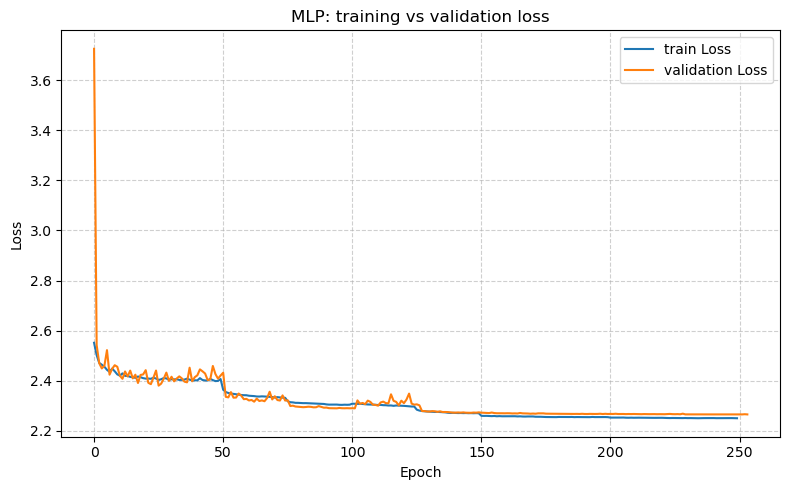

In [36]:
val_loss_list = list(np.load('checkpoints/val_loss.npy'))
train_loss_list = list(np.load('checkpoints/train_loss.npy'))
plot_loss(train_loss_list, val_loss_list)

In [37]:
def predict_probability(model, data_loader):
    model.eval()
    probability = []
    device = get_device()

    with torch.inference_mode():
        for x in data_loader:
            x = x.to(device)
            logits = model(x)
            probability.append(F.softmax(logits, dim=1).cpu().numpy())
    return np.vstack(probability)


In [38]:
# load model
input_dim = 124 # X_train.shape[1]
num_classes = 39 # len(np.unique(y_train))
model = SFCrimeMLP(input_dim=input_dim, num_classes=num_classes)
model.to(device)
model.load_state_dict(torch.load("./checkpoints/mlp.pth"))

# prepare test set
test_df = pd.read_csv("./dataset/test_processed.csv")
X_test = test_df[features].values
test_dataset  = CrimeDataset(X_test)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# save prediction probability
test_probs = predict_probability(model, test_loader)
submission = pd.DataFrame(test_probs, columns=meta["class_names"])
submission.insert(0, "Id", test_df["Id"].astype(int).values)
submission.to_csv("./submissions/mlp_submission.csv", index=False)